##Libraries Used

In [ ]:
# Import necessary packages
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, MaxPooling1D, LSTM, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sb

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Download and load GloVe word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
import numpy as np
# Create a dictionary to map words to their GloVe vectors
glove_embeddings = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

--2023-05-17 00:48:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-17 00:48:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-17 00:48:19--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

##Text Pre-processing

In [ ]:
#Read the data taken from kaggle
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df=train_df.drop(columns=["keyword","location","id"])

In [ ]:
test_df=test_df.drop(columns=["keyword","location","id"])

In [ ]:
train_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test_df.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
#Clean dataframe of tweets using stopwords
# converting to lower case
clean_tweets = train_df["text"].str.lower()
stop_words = set(stopwords.words('english'))

# removing stop words
clean_tweets = clean_tweets.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(clean_tweets)
word_index = tokenizer.word_index

In [ ]:
#creating an embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
sequences = tokenizer.texts_to_sequences(clean_tweets)
maxlen = 100
# truncating='post' removes excess words at the end
padded_sequences = pad_sequences(sequences, maxlen=maxlen, truncating='post')

In [ ]:
labels=train_df["target"]

##Neural Network Models

In [ ]:
# Model 1 Architecture
#Increase Droupout to attempt for better accuracy
#Edit embedding to match embedding used with GLoVe
model1 = tf.keras.Sequential([
    Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix],
              input_length=maxlen, trainable=False),
    Dropout(0.9),
    Conv1D(64, 5, activation='relu', padding='valid'),
    MaxPooling1D(pool_size=4),
    LSTM(64),
    Dense(1, activation='sigmoid')
])


In [ ]:
# Model 2 Architecture
#Adjust Drop out and add a second Drop out os similar value.
#Add more Dense layers and Bach Normalization.
model2 = tf.keras.Sequential([
    Embedding(len(tokenizer.word_index) + 1, 128, input_length=maxlen),
    Dropout(0.5),
    Conv1D(128, 5, activation='relu', padding='valid'),
    MaxPooling1D(pool_size=2),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dropout(0.6),
    Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Model 3 Architecture
#Adjust Drop out and add a second Drop out os similar value.
#Add more Dense layers and Bach Normalization
#Edit embedding to match embedding used with GLoVe
model3 = tf.keras.Sequential([
    Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix],
              input_length=maxlen, trainable=False),
    Dropout(0.2),  # Dropout layer with a dropout rate of 0.2
    Conv1D(64, 5, activation='relu', padding='valid'),
    MaxPooling1D(pool_size=4),
    LSTM(64),
    Dropout(0.5),  # another Dropout layer with a dropout rate of 0.5
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax'),
    Dense(1, activation='sigmoid')
])


In [ ]:
# Model Compilation (compile the desired model)
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

# Model Training
model1_result = model1.fit(
    padded_sequences, labels,
    epochs=10, validation_split=0.2,
    callbacks=[lr_scheduler]
)

Epoch 1/10
191/191 [==============================] - 18s 77ms/step - loss: 0.6174 - accuracy: 0.6662 - val_loss: 0.6253 - val_accuracy: 0.6441 - lr: 0.0010
Epoch 2/10
191/191 [==============================] - 9s 47ms/step - loss: 0.5756 - accuracy: 0.7117 - val_loss: 0.5762 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 3/10
191/191 [==============================] - 9s 48ms/step - loss: 0.5760 - accuracy: 0.7039 - val_loss: 0.6148 - val_accuracy: 0.6756 - lr: 0.0010
Epoch 4/10
191/191 [==============================] - 8s 40ms/step - loss: 0.5729 - accuracy: 0.7123 - val_loss: 0.5780 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 5/10
191/191 [==============================] - 9s 48ms/step - loss: 0.5600 - accuracy: 0.7213 - val_loss: 0.5993 - val_accuracy: 0.6986 - lr: 2.0000e-04
Epoch 6/10
191/191 [==============================] - 10s 50ms/step - loss: 0.5618 - accuracy: 0.7230 - val_loss: 0.6000 - val_accuracy: 0.7006 - lr: 2.0000e-04
Epoch 7/10
191/191 [==============================] - 

In [ ]:
# Model Compilation (compile the desired model)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

# Model Training
model2_result = model2.fit(
    padded_sequences, labels,
    epochs=10, validation_split=0.2,
    callbacks=[lr_scheduler]
)

Epoch 1/10
191/191 [==============================] - 65s 307ms/step - loss: 0.5901 - accuracy: 0.6918 - val_loss: 0.6302 - val_accuracy: 0.6855 - lr: 0.0010
Epoch 2/10
191/191 [==============================] - 61s 320ms/step - loss: 0.3991 - accuracy: 0.8381 - val_loss: 0.4890 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 3/10
191/191 [==============================] - 58s 305ms/step - loss: 0.3259 - accuracy: 0.8645 - val_loss: 0.4771 - val_accuracy: 0.7853 - lr: 0.0010
Epoch 4/10
191/191 [==============================] - 58s 304ms/step - loss: 0.2713 - accuracy: 0.8966 - val_loss: 0.5894 - val_accuracy: 0.7794 - lr: 0.0010
Epoch 5/10
191/191 [==============================] - 60s 314ms/step - loss: 0.2118 - accuracy: 0.9190 - val_loss: 0.7047 - val_accuracy: 0.7584 - lr: 0.0010
Epoch 6/10
191/191 [==============================] - 60s 317ms/step - loss: 0.1487 - accuracy: 0.9437 - val_loss: 0.7313 - val_accuracy: 0.7511 - lr: 2.0000e-04
Epoch 7/10
191/191 [============================

In [ ]:
# Model Compilation (compile the desired model)
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

# Model Training
model3_result = model3.fit(
    padded_sequences, labels,
    epochs=10, validation_split=0.2,
    callbacks=[lr_scheduler]
)

Epoch 1/10
191/191 [==============================] - 13s 51ms/step - loss: 0.5863 - accuracy: 0.7394 - val_loss: 0.5353 - val_accuracy: 0.7984 - lr: 0.0010
Epoch 2/10
191/191 [==============================] - 9s 45ms/step - loss: 0.5233 - accuracy: 0.7883 - val_loss: 0.5111 - val_accuracy: 0.7965 - lr: 0.0010
Epoch 3/10
191/191 [==============================] - 9s 45ms/step - loss: 0.4960 - accuracy: 0.8025 - val_loss: 0.4920 - val_accuracy: 0.8070 - lr: 0.0010
Epoch 4/10
191/191 [==============================] - 9s 49ms/step - loss: 0.4780 - accuracy: 0.8120 - val_loss: 0.4909 - val_accuracy: 0.7958 - lr: 0.0010
Epoch 5/10
191/191 [==============================] - 9s 48ms/step - loss: 0.4595 - accuracy: 0.8181 - val_loss: 0.4960 - val_accuracy: 0.7919 - lr: 0.0010
Epoch 6/10
191/191 [==============================] - 8s 42ms/step - loss: 0.4402 - accuracy: 0.8325 - val_loss: 0.4756 - val_accuracy: 0.7932 - lr: 0.0010
Epoch 7/10
191/191 [==============================] - 9s 48ms/s

In [ ]:
#tokenizing test data
test_sequences = tokenizer.texts_to_sequences(test_df['text'])
test_padded_sequences = pad_sequences(test_sequences, maxlen=100, padding='post', truncating='post')

In [ ]:
# predict using model 3 because of high accuracy
# Make predictions on the test set
y_pred = model3.predict(test_padded_sequences)

# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.49).astype(int)

# Print the predicted labels
print(y_pred_binary)
pd.set_option('display.max_colwidth', None)
test_df['pred'] = y_pred_binary
test_df.head()

102/102 [==============================] - 2s 14ms/step
[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


,text,pred
0,Just happened a terrible car crash,1
1,"Heard about #earthquake is different cities, stay safe everyone.",1
2,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",1
3,Apocalypse lighting. #Spokane #wildfires,1
4,Typhoon Soudelor kills 28 in China and Taiwan,1


Text(0, 0.5, 'Rates')

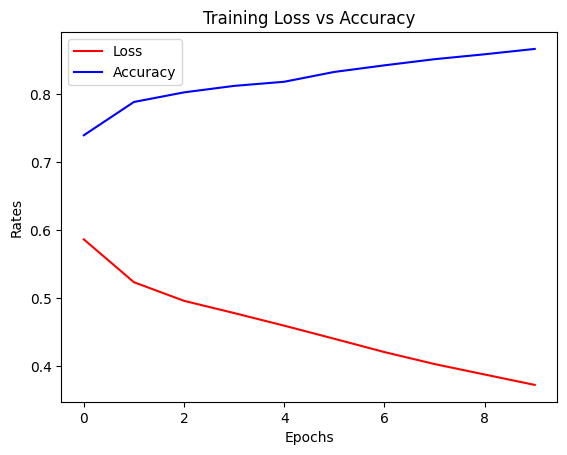

In [ ]:
sb.lineplot(data=model3_result.history['loss'], label='Loss', color= 'red')
lplot = sb.lineplot(data=model3_result.history['accuracy'], label='Accuracy', color= 'blue')
lplot.set_title('Training Loss vs Accuracy')
lplot.set_xlabel('Epochs')
lplot.set_ylabel('Rates')

In [ ]:
# preparing data to visualize +ve and -ve proportion
res = ["Positive" if value[0] == 1 else "Negative" for value in y_pred_binary]

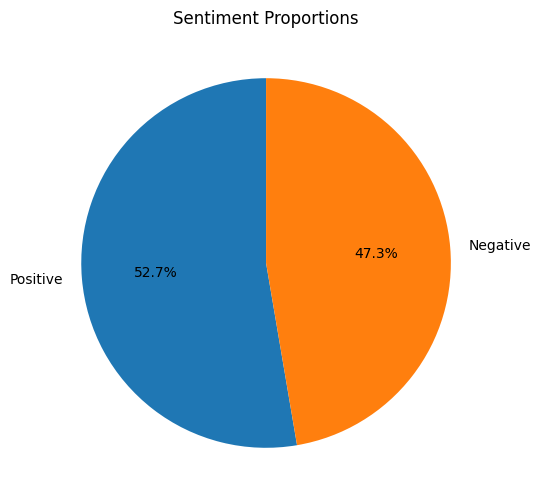

In [ ]:
# Plotting chart to view the proportion of -ve's and +ve's
sentiment_counts = Counter(res)
labels, counts = zip(*sentiment_counts.items())

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Proportions')
plt.show()

In [ ]:
#reading the sample submissions file
df_submission = pd.read_csv('sample_submission.csv')
df_submission.shape

(3263, 2)

In [ ]:
#adding the predicted result as a target column
df_submission['target'] = y_pred_binary
df_submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [ ]:
# outputs the predictions to the file 'my_submission.csv'
df_submission.to_csv('my_submission.csv',index=False)